In [85]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,5)
import datetime
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))
from sklearn.metrics import mean_squared_error
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/BIIB_data.csv


# DATA 
The data is actually about the price of wheat

In [86]:
df = pd.read_csv("/kaggle/input/BIIB_data.csv")

In [87]:
df.shape

(1259, 7)

In [88]:
df.head()

,date,open,high,low,close,volume,Name
0,2/8/2013,163.57,165.80,162.325,164.44,1163956,BIIB
1,2/11/2013,164.51,165.28,163.055,163.96,1036172,BIIB
2,2/12/2013,163.98,165.94,163.320,165.45,1079829,BIIB
3,2/13/2013,163.39,167.29,163.340,165.91,1378081,BIIB
4,2/14/2013,165.67,165.77,163.450,164.59,1203561,BIIB


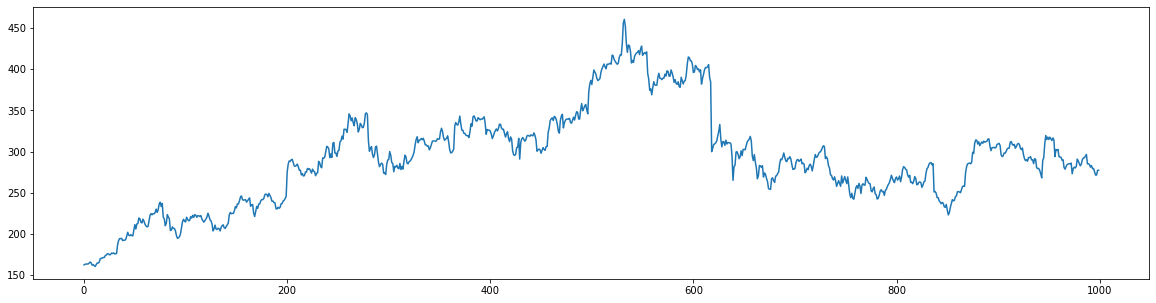

In [89]:
df_stocks = df.iloc[:1000, 3]       #first 300 are to fit the model
df_holdout= df.iloc[1000: , 3]      #validation set
df_stocks.plot()

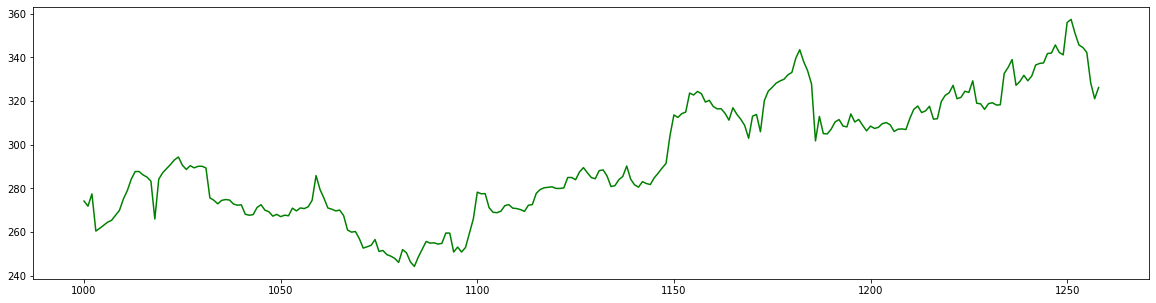

In [90]:
df_holdout.plot(color='green')

### Plot differenced time series

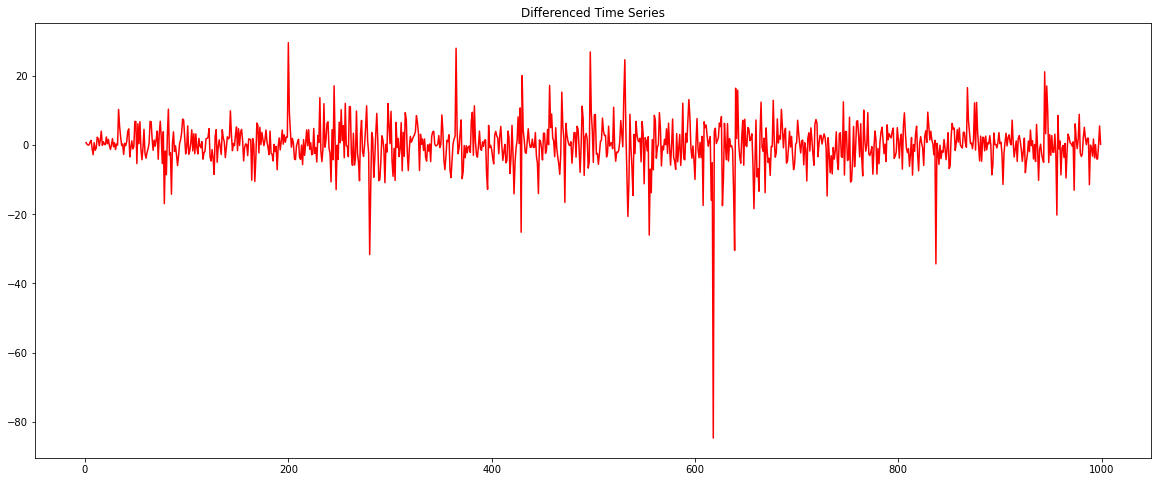

In [91]:
df_stocks_diff = df_stocks-df_stocks.shift()
plt.figure(figsize=(20,8))
plt.title('Differenced Time Series')
df_stocks_diff.plot(color='red')

this looks like a perfect data to modelling. It has few outliers but they can be ignore.

In [92]:
df_stocks_diff.head()

0      NaN
1    0.730
2    0.265
3    0.020
4    0.110
Name: low, dtype: float64

In [93]:
#first value is NaN so replace it with original time series
df_stocks_diff.iloc[0] = df_stocks.iloc[0]

In [94]:
df_stocks_diff.head()

0    162.325
1      0.730
2      0.265
3      0.020
4      0.110
Name: low, dtype: float64

# Lets introduce ACF (Autocorrelation plot) and PACF(Partial autocorrelation plot):
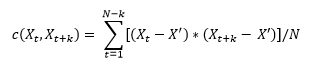
Where X’ is the mean, k is the lag (number of time steps we look back. k=1 means t-1), N is the total number of points. C is the autocovariance. For a stationary time series, c does not depend on t. It only depends on k or the lag.

In [95]:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(df_stocks, nlags=10)    #for 10 lags
lag_pacf = pacf(df_stocks, nlags=10, method='ols')   #for 10 lags

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


### Plot this

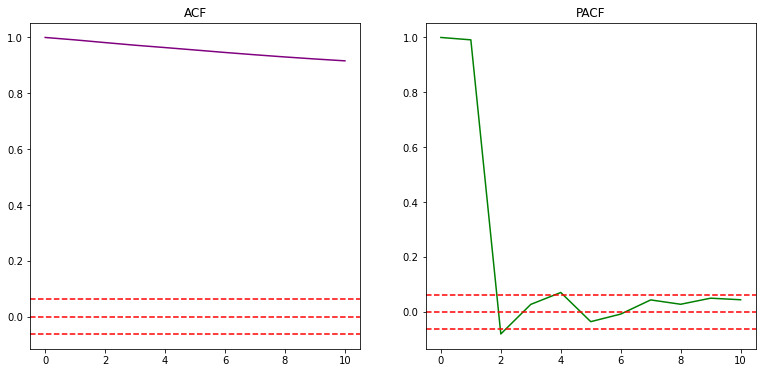

In [96]:
plt.figure(figsize=(13,6))
plt.subplot(121)
plt.title('ACF')
plt.plot(lag_acf, color='purple')
plt.axhline(y=0, linestyle='--', color = 'red')
plt.axhline(y=-1.96/np.sqrt(len(df_stocks_diff)), linestyle='--', color='red')
plt.axhline(y = 1.96/np.sqrt(len(df_stocks_diff)), linestyle='--', color='red')

plt.subplot(122)
plt.title('PACF')
plt.plot(lag_pacf, color='green')
plt.axhline(y=0, linestyle='--', color='red')
plt.axhline(y=-1.96/np.sqrt(len(df_stocks_diff)), linestyle='--', color='red')
plt.axhline(y = 1.96/np.sqrt(len(df_stocks_diff)), linestyle='--', color='red')

### FOR ACF
From lag 0 it decays gradually. The top and bottom grey dashed lines show the significance level. Between these levels, the autocorrelation is attributed to noise and not some actual relation. Therefore q=0

### FOR PACF
It cuts off quickly, unlike the gradual decay in ACF. Lag 1 is significantly high, indicating the presence of 1 AR term. Therefore p=1.

fir our ARIMA(p=1,d=1,q=0) model. 

# Fitting ARIMA

In [97]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(df_stocks, order=(2,1,1))
results_AR = model.fit(disp=-1)

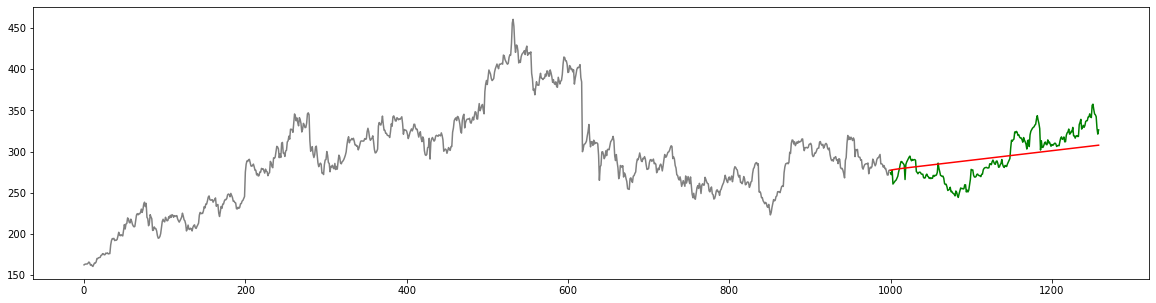

In [98]:
pred_AR = results_AR.predict(start=len(df_stocks_diff), end=len(df_stocks_diff) + 258)
pred_AR.iloc[0] = pred_AR.iloc[0] + df_stocks.iloc[998]
pred_AR = pred_AR.cumsum()
pred_AR.head()

pred_AR.index = df_holdout.index

plt.plot(df_stocks, color='grey')
plt.plot(df_holdout, color='green')
plt.plot(pred_AR, color='red')

* Grey --> data on which model is fitted
* Green --> holdout/validation data
* Red --> our model's performance

### REsult

In [99]:
error = mean_squared_error(df_holdout, pred_AR)
print("Current Error of our model is ", error)

Current Error of our model is  439.3875682752721


# Machine Learnign And Deep Learning

#### Now lets make a model using deep learning and machine learning and lets check the error of this 

THe model which gives the better accuracry will be considered as the best one

In [100]:
df = pd.read_csv("/kaggle/input/BIIB_data.csv")
df.head()

,date,open,high,low,close,volume,Name
0,2/8/2013,163.57,165.80,162.325,164.44,1163956,BIIB
1,2/11/2013,164.51,165.28,163.055,163.96,1036172,BIIB
2,2/12/2013,163.98,165.94,163.320,165.45,1079829,BIIB
3,2/13/2013,163.39,167.29,163.340,165.91,1378081,BIIB
4,2/14/2013,165.67,165.77,163.450,164.59,1203561,BIIB


In [101]:
from datetime import datetime

In [102]:
def components(x):
    #function to extract date, month and year as a feature
    date = datetime.strptime(x, '%m/%d/%Y')
    return (date.day,date.month,date.year)

df['Day'] = df['date'].apply(lambda x:components(x)[0])
df['Month'] = df['date'].apply(lambda x:components(x)[1])
df['Year'] = df['date'].apply(lambda x:components(x)[2])

In [103]:
df.head()

,date,open,high,low,close,volume,Name,Day,Month,Year
0,2/8/2013,163.57,165.80,162.325,164.44,1163956,BIIB,8,2,2013
1,2/11/2013,164.51,165.28,163.055,163.96,1036172,BIIB,11,2,2013
2,2/12/2013,163.98,165.94,163.320,165.45,1079829,BIIB,12,2,2013
3,2/13/2013,163.39,167.29,163.340,165.91,1378081,BIIB,13,2,2013
4,2/14/2013,165.67,165.77,163.450,164.59,1203561,BIIB,14,2,2013


In [104]:
#Prepare x and y variable
y = df['close']
df = df.drop(['Name', 'date','close','open','volume','high', 'low'],1)

In [105]:
df.head()

,Day,Month,Year
0,8,2,2013
1,11,2,2013
2,12,2,2013
3,13,2,2013
4,14,2,2013


In [106]:
df.shape

(1259, 3)

In [107]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [108]:
scale = MinMaxScaler()
df = scale.fit_transform(df)

In [109]:
pd.DataFrame(df).head()

,0,1,2
0,0.233333,0.090909,0.0
1,0.333333,0.090909,0.0
2,0.366667,0.090909,0.0
3,0.400000,0.090909,0.0
4,0.433333,0.090909,0.0


In [111]:
df_train = df[:1100,:]
y_train = np.array(y.iloc[:1100])
df_test = df[1100:,:]
y_test = np.array(y.iloc[1100:])


In [112]:
df_train.shape, df_test.shape

((1100, 3), (159, 3))

In [113]:
model= Sequential()
model.add(LSTM(250, input_shape=(df_train.shape[1],1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [114]:
df_train= df_train.reshape((df_train.shape[0], df_train.shape[1], 1))
df_test = df_test.reshape((df_test.shape[0], df_test.shape[1],1))

In [115]:
model.fit(df_train, y_train, epochs=400, shuffle=False)

Epoch 1/400
35/35 [==============================] - 0s 3ms/step - loss: 88094.6250
Epoch 2/400
35/35 [==============================] - 0s 3ms/step - loss: 76043.4688
Epoch 3/400
35/35 [==============================] - 0s 3ms/step - loss: 66180.0625
Epoch 4/400
35/35 [==============================] - 0s 3ms/step - loss: 60507.6875
Epoch 5/400
35/35 [==============================] - 0s 3ms/step - loss: 55667.3359
Epoch 6/400
35/35 [==============================] - 0s 3ms/step - loss: 51354.8672
Epoch 7/400
35/35 [==============================] - 0s 3ms/step - loss: 47454.8203
Epoch 8/400
35/35 [==============================] - 0s 3ms/step - loss: 43894.5898
Epoch 9/400
35/35 [==============================] - 0s 3ms/step - loss: 40622.6992
Epoch 10/400
35/35 [==============================] - 0s 3ms/step - loss: 37602.0703
Epoch 11/400
35/35 [==============================] - 0s 3ms/step - loss: 34805.3398
Epoch 12/400
35/35 [==============================] - 0s 3ms/step - loss: 

35/35 [==============================] - 0s 3ms/step - loss: 3214.7734
Epoch 99/400
35/35 [==============================] - 0s 3ms/step - loss: 3214.9785
Epoch 100/400
35/35 [==============================] - 0s 3ms/step - loss: 3215.1797
Epoch 101/400
35/35 [==============================] - 0s 3ms/step - loss: 3215.3816
Epoch 102/400
35/35 [==============================] - 0s 3ms/step - loss: 3215.5723
Epoch 103/400
35/35 [==============================] - 0s 3ms/step - loss: 3215.7646
Epoch 104/400
35/35 [==============================] - 0s 3ms/step - loss: 3215.9531
Epoch 105/400
35/35 [==============================] - 0s 3ms/step - loss: 3216.1365
Epoch 106/400
35/35 [==============================] - 0s 3ms/step - loss: 3216.3149
Epoch 107/400
35/35 [==============================] - 0s 3ms/step - loss: 3216.4932
Epoch 108/400
35/35 [==============================] - 0s 3ms/step - loss: 3216.6658
Epoch 109/400
35/35 [==============================] - 0s 3ms/step - loss: 3216.

35/35 [==============================] - 0s 3ms/step - loss: 3222.7207
Epoch 195/400
35/35 [==============================] - 0s 3ms/step - loss: 3222.7385
Epoch 196/400
35/35 [==============================] - 0s 3ms/step - loss: 3222.7551
Epoch 197/400
35/35 [==============================] - 0s 3ms/step - loss: 3222.7715
Epoch 198/400
35/35 [==============================] - 0s 3ms/step - loss: 3222.7876
Epoch 199/400
35/35 [==============================] - 0s 3ms/step - loss: 3222.8042
Epoch 200/400
35/35 [==============================] - 0s 3ms/step - loss: 3222.8174
Epoch 201/400
35/35 [==============================] - 0s 3ms/step - loss: 3222.8308
Epoch 202/400
35/35 [==============================] - 0s 3ms/step - loss: 3222.8445
Epoch 203/400
35/35 [==============================] - 0s 3ms/step - loss: 3222.8582
Epoch 204/400
35/35 [==============================] - 0s 3ms/step - loss: 3222.8726
Epoch 205/400
35/35 [==============================] - 0s 3ms/step - loss: 3222

35/35 [==============================] - 0s 4ms/step - loss: 3223.2195
Epoch 291/400
35/35 [==============================] - 0s 4ms/step - loss: 3223.2197
Epoch 292/400
35/35 [==============================] - 0s 4ms/step - loss: 3223.2197
Epoch 293/400
35/35 [==============================] - 0s 4ms/step - loss: 3223.2207
Epoch 294/400
35/35 [==============================] - 0s 4ms/step - loss: 3223.2214
Epoch 295/400
35/35 [==============================] - 0s 3ms/step - loss: 3223.2209
Epoch 296/400
35/35 [==============================] - 0s 3ms/step - loss: 3223.2212
Epoch 297/400
35/35 [==============================] - 0s 3ms/step - loss: 3223.2222
Epoch 298/400
35/35 [==============================] - 0s 3ms/step - loss: 3223.2219
Epoch 299/400
35/35 [==============================] - 0s 3ms/step - loss: 3223.2217
Epoch 300/400
35/35 [==============================] - 0s 3ms/step - loss: 3223.2217
Epoch 301/400
35/35 [==============================] - 0s 3ms/step - loss: 3223

35/35 [==============================] - 0s 3ms/step - loss: 3223.2080
Epoch 387/400
35/35 [==============================] - 0s 3ms/step - loss: 3223.2070
Epoch 388/400
35/35 [==============================] - 0s 3ms/step - loss: 3223.2075
Epoch 389/400
35/35 [==============================] - 0s 3ms/step - loss: 3223.2073
Epoch 390/400
35/35 [==============================] - 0s 3ms/step - loss: 3223.2065
Epoch 391/400
35/35 [==============================] - 0s 3ms/step - loss: 3223.2061
Epoch 392/400
35/35 [==============================] - 0s 3ms/step - loss: 3223.2063
Epoch 393/400
35/35 [==============================] - 0s 3ms/step - loss: 3223.2058
Epoch 394/400
35/35 [==============================] - 0s 3ms/step - loss: 3223.2056
Epoch 395/400
35/35 [==============================] - 0s 3ms/step - loss: 3223.2056
Epoch 396/400
35/35 [==============================] - 0s 3ms/step - loss: 3223.2056
Epoch 397/400
35/35 [==============================] - 0s 3ms/step - loss: 3223

In [117]:
pred_lstm = model.predict(df_test)
train_val = pd.DataFrame(y_train, index = range(1100))
holdout_predictions = pd.DataFrame(pred_lstm, index = range(1100, 1100+len(pred_lstm)))
holdout_val = pd.DataFrame(y_test, index = range(1100, 1100+len(pred_lstm)))

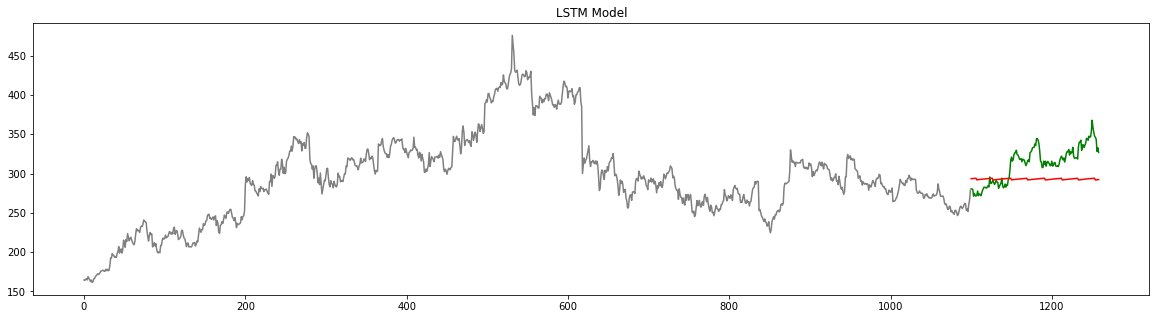

In [120]:
plt.title('LSTM Model')
plt.plot(train_val, color='grey')
plt.plot(holdout_val, color ='green')
plt.plot(holdout_predictions, color='red')

In [121]:
error = mean_squared_error(holdout_val, pred_lstm)
print(error)

894.0133541877839


# Lets use Random Forest ALGO 

In [122]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [128]:
param_dict = {'n_estimators':[1,5,10]}
rf = RandomForestRegressor()
cv = GridSearchCV(rf, param_grid=param_dict, scoring='neg_mean_squared_error')
df_train = df[:1100, :]
y_train = np.array(y.iloc[:1100])
df_test = df[1100:, :]
y_test = np.array(y.iloc[1100:])

In [129]:
cv.fit(df_train, y_train)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'n_estimators': [1, 5, 10]},
             scoring='neg_mean_squared_error')

In [130]:
cv.best_score_

-5421.701325255551

### Plot

In [131]:
pred_rf = cv.best_estimator_.predict(df_test)
train_val = pd.DataFrame(y_train, index = range(1100))
holdout_pred = pd.DataFrame(pred_rf, index=range(1100, 1100+len(pred_rf)))
holdout_values = pd.DataFrame(y_test, index=range(1100,1100+len(pred_rf)))

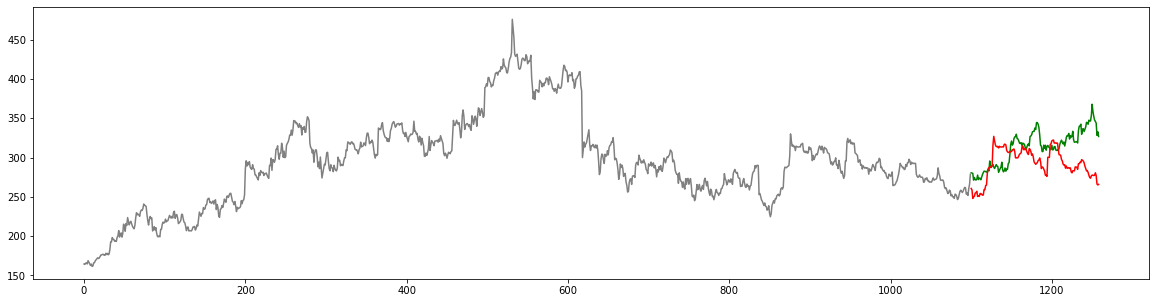

In [133]:
plt.plot(train_val, color='grey')
plt.plot(holdout_val, color='green')
plt.plot(holdout_pred, color='red')

In [ ]:
error = mean_squared_error(y_test, pred_rf)
print(error)